## init

In [2]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


# thing go bbrrr

|======== Timed report ========
| reduce sparse              :     533.57ms  (533.573ms per; #1)
| vineyard.get_state_at_point:     423.29ms  ( 0.003ms per; #130687)
| reduce_vine: ordering      :  322060.80ms  ( 2.464ms per; #130687)
| from sparse                :      16.51ms  ( 2.752ms per; #6)
| mars.reduce_vine           :  144496.09ms  ( 1.106ms per; #130687)
| reduce_vine.almost-all     :  167889.70ms  ( 1.285ms per; #130687)
|==============================


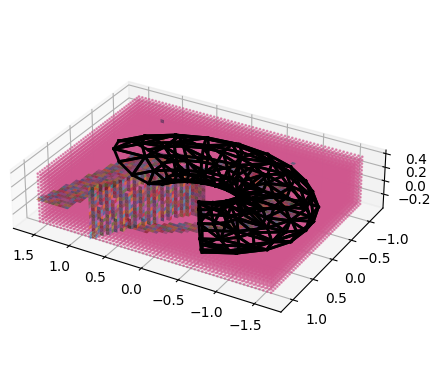

In [7]:
example = ex.maybepipe


###################

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
swaps = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)
  
  def prune(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    swaps.append((s1, s2, old_state, new_state))

    if s1.dim() == example.medial_axis:
      per_1 = vin.compute_persistence(s1, old_state.ordering, old_state.R)
      per_2 = vin.compute_persistence(s2, new_state.ordering, new_state.R)
      if per_1 < 0.01 or per_2 < 0.01:
        return True

    return vin.prune_euclidean(our_complex, s1, s2, old_state.point, new_state.point, example.prune_eps)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    super().on_faustian(s1, s2, old_state.point, new_state.point)
    if s1.dim() == example.medial_axis:
      c1 = gridd.cell_of(old_state.point)
      c2 = gridd.cell_of(new_state.point)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)

## histogram

num swaps  = 3081727615
#vertices  = 748
#edges     = 2250
#triangles = 1500
grid size =  (22, 30, 8, 3)

bound = 2585551200.0
ratio = 1.192
[660845, 595615, 708090, 639994, 197132, 166046, 619204, 713660, 659338, 214447, 160606, 569382, 730353, 636556, 208182, 160000, 661009, 593720, 641398, 201313, 163734, 694969, 579483, 643173, 182876, 170612, 677470, 592047, 741433, 626078, 182894, 661763, 591033, 681732, 647364, 164846, 591390, 714714, 638123, 198394, 168559, 617052, 656406, 218674, 164608, 657015, 661764, 189104, 176482, 601481, 738485, 656837, 201910, 628371, 679524, 669592, 162530, 436342, 720414, 611365, 181720, 151500, 568411, 646487, 206556, 166428, 520989, 596818, 177786, 164659, 575564, 746895, 637510, 194539, 561374, 712421, 635051, 160358, 692053, 577365, 641989, 180099, 167951, 676960, 594383, 627972, 188222, 661469, 590428, 646305, 164843, 681864, 579476, 603517, 182721, 172449, 691243, 582973, 646550, 170386, 699573, 574368, 642574, 171708, 660810, 593904, 705001, 64

Text(0.5, 1.0, 'Histogram of the nubmer of transpositions per run of vineyards')

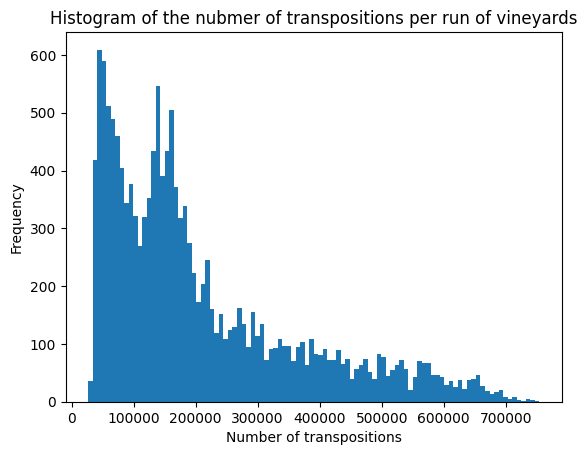

In [19]:
print(f'num swaps  = {v.num_swaps}')
V = len(our_complex.vertlist)
print(f'#vertices  = {V}')
E = len(our_complex.edgelist)
print(f'#edges     = {E}')
F = len(our_complex.trilist)
print(f'#triangles = {F}')
G = sum(gridd.a.shape[:3])
print(f'grid size = ', gridd.a.shape)

our_bound = V*(V-1)//2 * (G/3)**2 + E*(E-1) * (G/3)**2 + F*(F-1)//2 * (G/3)**2
print()
print(f'bound = {our_bound}')
print(f'ratio = {v.num_swaps / our_bound:.3f}')

print(v.swap_counts)
plt.hist(v.swap_counts, bins=100)
plt.xlabel('Number of transpositions')
plt.ylabel('Frequency')
plt.title('Histogram of the nubmer of transpositions per run of vineyards')

# 66024 faustian swaps
# 116'637'796 total swaps

# newest pruning

In [9]:
import math
med_ax_dim = 1
euc_prune_param = 4
conditional_pers_prune = False
always_pers_prune = True
persistence = 1*euc_prune_param
pers_prune_eps = .01 # default 0.01
##############################
# for eps in [5, 9.98 * 1 / math.sqrt(2), 10 / math.sqrt(2)]:
ffaces = []
for (s1, s2, a, b) in swaps:
  if vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, euc_prune_param):
    continue
  # smarter prune? 
  if s1.dim() == med_ax_dim and conditional_pers_prune:
      if vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, euc_prune_param) or always_pers_prune:
        per_1 = vin.compute_persistence(s1, a.ordering, a.R)
        per_2 = vin.compute_persistence(s2, b.ordering, b.R)
        if per_1 < persistence or per_2 < persistence:
          continue
  if s1.dim() == med_ax_dim:
    c1 = gridd.cell_of(a.point)
    c2 = gridd.cell_of(b.point)
    ffaces.append(gridd.dual_face(c1, c2))
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, ffaces, CameraOpt(azim=120, elev=50), skip_grid=True, skip_cube=True)
fig.show()
export_obj(example, our_complex, ffaces)

KeyboardInterrupt: 

- $n$ is number of vertices (the number of swaps is just tracking verts) so it is higher
- matrix split is roughly 3x speedup (from if you have a perfect split between 1:1:1 v:e:f we just pretend numb of swaps sq in numb simplices then that means it's about 9$n^2$ where $n$ is now v+f+e instead of just v) if you split, you have 3$n^2$\\
- adaptive grid doesn't work very well because you have to vineyards to check if subdivide, and then even more vineyards\\
- adaptive grid doesn't start becoming better until very dense
leaf = number of subdiv
count is numb of full grid vineyards, crosses is in adaptive grid\\

LEAF = 3,
count   = 170,
crosses = 182

LEAF = 4,
count   = 682,
crosses = 748

LEAF = 5,
count   = 2'730,
crosses = 2'264

LEAF = 6,
count   = 10'922,
crosses =  5'672

LEAF = 7,
count   = 43'690,
crosses = 12'582